# Data Normalization & Standardization

## Imports

In [37]:
import pandas as pd
import numpy as np
from sklearn import set_config
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
import plotly.express as px
from scipy import stats

In [38]:
import warnings
warnings.filterwarnings("ignore")

We'll configure scikit-learn to output in a pandas dataframe to save us having to marry columns to numpy arrays to get DF's again

In [39]:
set_config(transform_output="pandas")

Remove the target variables

In [40]:
initial_df = pd.read_csv('HMEQ_Loss.csv')
no_targets_df = initial_df.drop(['TARGET_BAD_FLAG','TARGET_LOSS_AMT'],axis=1)

Split our dataset into categorical and numerical

In [41]:
# cat only
categorical_columns = no_targets_df.select_dtypes('object')

# num only
numerical_columns = no_targets_df.select_dtypes(exclude='object')


## Impute missing  values

For numerical, we can use the median to fill in the missing values

In [42]:
# for our numerical friends
dropholder = []
for col in numerical_columns:  
    if numerical_columns[col].isna().mean() > 0:
        numerical_columns['imp_'+col] = numerical_columns[col].fillna(numerical_columns[col].median())
        dropholder.append(col)
    else:
        continue

numerical_columns.drop(dropholder,axis=1,inplace=True)

For categorical, we can use the mode (aka the most frequently appearing value)

In [43]:
# for our categorical friends
dropholder = []
for col in categorical_columns:  
    if categorical_columns[col].isna().mean() > 0:
        colmode = categorical_columns[col].value_counts().index[0]
        categorical_columns['imp_'+col] = categorical_columns[col].fillna(colmode)
        dropholder.append(col)
    else:
        continue

categorical_columns.drop(dropholder,axis=1,inplace=True)

## Standardization

For standardization we use StandardScaler().

The formula is below:

z = (x - u) / s

Step 1 is to instantiate the Standard Scaler

In [44]:
standardizer = StandardScaler()
standardizer.fit(numerical_columns)

StandardScaler()

Step 2 is to transform our numerical columns into a new dataframe called standardized

In [45]:
standardized = standardizer.transform(numerical_columns)
standardized = standardized.add_prefix('std_')
standardized.head()

,std_LOAN,std_imp_MORTDUE,std_imp_VALUE,std_imp_YOJ,std_imp_DEROG,std_imp_DELINQ,std_imp_CLAGE,std_imp_NINQ,std_imp_CLNO,std_imp_DEBTINC
0,-1.562299,-1.107920,-1.099371,0.240237,-0.280976,-0.375943,-1.018026,-0.102879,-1.230878,0.106963
1,-1.544453,-0.069286,-0.582794,-0.241936,-0.280976,1.477341,-0.689350,-0.707574,-0.728389,0.106963
2,-1.526606,-1.398407,-1.491970,-0.655226,-0.280976,-0.375943,-0.358680,-0.102879,-1.130380,0.106963
3,-1.526606,-0.187596,-0.216389,-0.241936,-0.280976,-0.375943,-0.071488,-0.102879,-0.125403,0.106963
4,-1.508759,0.582831,0.183939,-0.792990,-0.280976,-0.375943,-1.030391,-0.707574,-0.728389,0.106963


## K-means clustering

For our initial clustering, let's use YOJ, CLAGE, and LOAN.

YOJ gives us their job stability. 

CLAGE gives us how long they've had credit.

LOAN gives us how much they're asking for. 

These three together should give us some nice clusters when we think about who wants a loan. If CLAGE is low and YOJ is low but LOAN is high, that seems like a high-risk grouping of applicants. Potentially a target a for higher interest rates at a much smaller loan amount than they asked for. 

If YOJ is high, CLAGE is low, and LOAN is high, it might just mean they've never needed to use credit. It captures the edge case pretty well. This cluster might be people just starting their credit journey. These could be middle of the road rates with almost the entirety of what they asked for. 



In [46]:
smalldf = standardized[['std_imp_YOJ', 'std_LOAN', 'std_imp_CLAGE']]

K_LIST = []
I_LIST = []
S_LIST = []
C_LIST = []

for K in range(3,9):
    km = KMeans(n_clusters = K, random_state = 1)
    km.fit (smalldf)
    Y = km.predict(smalldf)
    K_LIST.append(K)
    I_LIST.append(km.inertia_)
    S_LIST.append(silhouette_score(smalldf, km.labels_))
    C_LIST.append(calinski_harabasz_score(smalldf, km.labels_))


In [47]:
def drawElbow(K, SCORE, LABEL) :
    plt.plot(K , SCORE, 'ro-', linewidth=2)
    plt.title(LABEL)
    plt.xlabel('Clusters')
    plt.ylabel('Score')
    plt.show()

Based on the graphgs below, we can see that for Inertia, we start to get diminishing returns around 4 or 5. We'll include 6 to give us a nice range

For silhouette 3,4 clusters give us the highest score. 5,6 provide comparable results.

For Calinski, 4 clusters is a big peak. 5,6 are the next highest. 

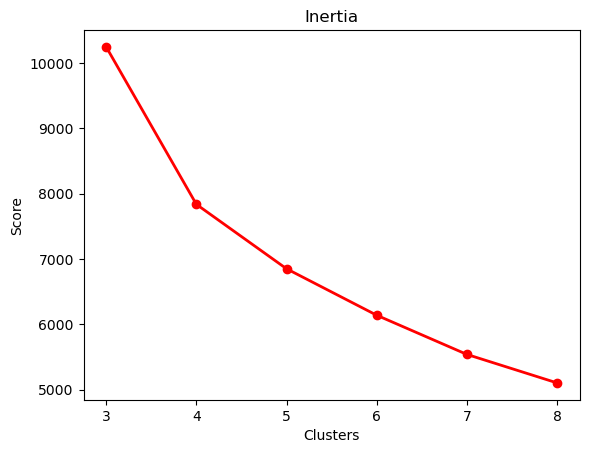

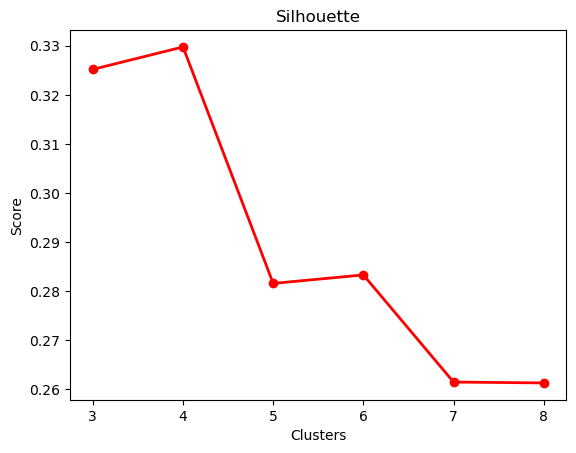

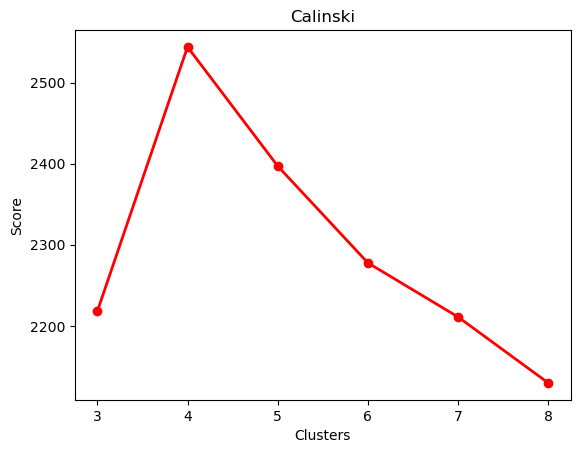

In [48]:
drawElbow( K_LIST, I_LIST, "Inertia" )
drawElbow( K_LIST, S_LIST, "Silhouette" )
drawElbow( K_LIST, C_LIST, "Calinski" )

### Visualizing and Understanding Our Clustering

In [49]:
model = KMeans(n_clusters=4, random_state=1)
model.fit(standardized)
clusters = model.predict(standardized)

In [50]:
initial_df

,TARGET_BAD_FLAG,TARGET_LOSS_AMT,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,641.0,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1109.0,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,767.0,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1425.0,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,NaN,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,NaN,88900,57264.0,90185.0,DebtCon,Other,16.0,0.0,0.0,221.808718,0.0,16.0,36.112347
5956,0,NaN,89000,54576.0,92937.0,DebtCon,Other,16.0,0.0,0.0,208.692070,0.0,15.0,35.859971
5957,0,NaN,89200,54045.0,92924.0,DebtCon,Other,15.0,0.0,0.0,212.279697,0.0,15.0,35.556590
5958,0,NaN,89800,50370.0,91861.0,DebtCon,Other,14.0,0.0,0.0,213.892709,0.0,16.0,34.340882


In [51]:
merged_with_cluster = pd.concat((initial_df['TARGET_BAD_FLAG'],categorical_columns), axis=1)
merged_with_cluster = pd.concat((merged_with_cluster,numerical_columns), axis=1)
merged_with_cluster['cluster'] = clusters
merged_with_cluster.head()

,TARGET_BAD_FLAG,imp_REASON,imp_JOB,LOAN,imp_MORTDUE,imp_VALUE,imp_YOJ,imp_DEROG,imp_DELINQ,imp_CLAGE,imp_NINQ,imp_CLNO,imp_DEBTINC,cluster
0,1,HomeImp,Other,1100,25860.0,39025.0,10.5,0.0,0.0,94.366667,1.0,9.0,34.818262,1
1,1,HomeImp,Other,1300,70053.0,68400.0,7.0,0.0,2.0,121.833333,0.0,14.0,34.818262,1
2,1,HomeImp,Other,1500,13500.0,16700.0,4.0,0.0,0.0,149.466667,1.0,10.0,34.818262,1
3,1,DebtCon,Other,1500,65019.0,89235.5,7.0,0.0,0.0,173.466667,1.0,20.0,34.818262,1
4,0,HomeImp,Office,1700,97800.0,112000.0,3.0,0.0,0.0,93.333333,0.0,14.0,34.818262,1


In [52]:
merged_with_cluster = merged_with_cluster[(np.abs(stats.zscore(merged_with_cluster['imp_CLAGE'])) < 3)]
merged_with_cluster['cluster'] = merged_with_cluster['cluster'].astype(str)
merged_with_cluster['TARGET_BAD_FLAG'] = merged_with_cluster['TARGET_BAD_FLAG'].astype(str)

Let's look at our what our clustering did to the target bad flag.

In [53]:
merged_with_cluster.groupby('cluster')['TARGET_BAD_FLAG'].value_counts()

cluster  TARGET_BAD_FLAG
0        0                  1164
         1                   128
1        0                  2568
         1                   628
2        1                   271
         0                   123
3        0                   888
         1                   159
Name: TARGET_BAD_FLAG, dtype: int64

Let's also take a peek at the centers. We can see from YOJ that there might not be enough variance for the number of clusters we have. If it was wider spread, the means maybe wouldn't be stacked on top of each other for clusters 1-3. 

In [54]:
merged_with_cluster.groupby('cluster')[['imp_YOJ','LOAN','imp_CLAGE']].mean()

,imp_YOJ,LOAN,imp_CLAGE
cluster,,,
0,17.786920,20239.473684,235.879922
1,5.577394,15466.270338,144.513383
2,7.842132,17987.055838,165.049525
3,7.526170,26337.917861,209.162920


The visualization is a bit chaotic but we can read :

- Left to right as the CLAGE. 

- Top to bottom as the YOJ. 

- Size as the LOAN. 

- The colors represent how our model clustered these people. 

The mass of blue on the bottom left represents our first cluster. These are our younger folks who have less years on the job and limited credit history.

The mass of purple in the middle represent seasoned industry vets who have been on the job for a bit and have some credit history. 

The mass of teal at the top part represents our long working people with many years on the job and varying credit histories.

The interspersed orange is not a clean break but useful in that it's interspersed. We can choose to read it as a clear indicator that 4 groups is too much or that this cluster is an inbetweener cluster

In [55]:
fig1 = px.scatter(merged_with_cluster, x="imp_CLAGE", y="imp_YOJ", size='LOAN', color="cluster")
fig1.update_layout(title="Clusters")
fig1.show()

We can try to predict our TARGET_BAD_FLAG target but the visualization below shows that it's messing. Red = No default, Blue = Default. You can see that at almost point we can imagine, we have both defaults and non-defaults. This may be due to the poor choice of variables, a poor choice for number of clusters, or a combination of both. Further testing should be done to see what combination of variables and clusters can get us a clearer view

In [56]:
fig1 = px.scatter(merged_with_cluster, x="imp_CLAGE", y="imp_YOJ", symbol="cluster", color='TARGET_BAD_FLAG')
fig1.update_layout(title="Clusters")
fig1.show()

## BINGO BONUS: PCA COMBO

Let's try using PCA + Kmeans. We'll use more than our 3 variables PCA make to make components for our clustering variables

2.22 variation= 22 %  total= 22 %
1.4 variation= 14 %  total= 36 %
1.24 variation= 12 %  total= 48 %
1.0 variation= 10 %  total= 58 %
0.96 variation= 10 %  total= 68 %
0.85 variation= 8 %  total= 76 %
0.78 variation= 8 %  total= 84 %
0.72 variation= 7 %  total= 91 %
0.63 variation= 6 %  total= 98 %
0.2 variation= 2 %  total= 100 %


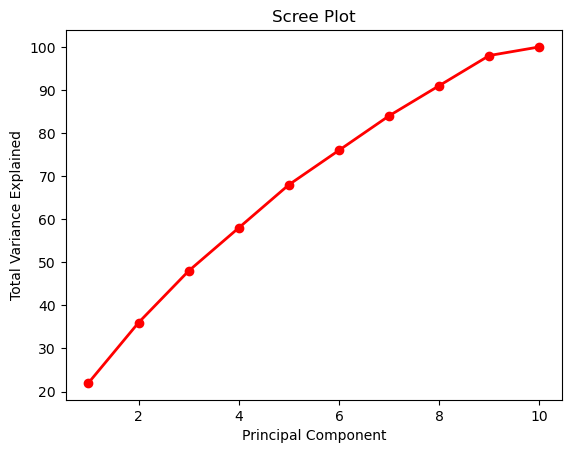

In [57]:
pca = PCA(n_components=standardized.shape[1])
pca.fit(standardized)
ev = pca.explained_variance_
varPCT = []
totPCT = []
total = 0
for i in ev:
    total = total + i
    VAR = round( i / len(ev) * 100)
    PCT = int( total / len(ev) * 100)
    varPCT.append(VAR)
    totPCT.append( PCT )
    print( round(i,2), "variation=", VAR,"%"," total=", PCT,"%")

PC_NUM = np.arange( standardized.shape[1] ) + 1
plt.plot( PC_NUM , totPCT, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Total Variance Explained')
plt.show()

pca_df = pd.DataFrame(pca.transform(standardized))
pca_df = pca_df.iloc[:,0:9]

pca_kmeans = KMeans(n_clusters=4, random_state=1)
pca_kmeans.fit(pca_df)
pca_clusters = pca_kmeans.predict(pca_df)

pca_final_df = pd.concat((initial_df['TARGET_BAD_FLAG'],pca_df), axis = 1)
pca_final_df['clusters'] = pca_clusters

In [58]:
K_LIST = []
I_LIST = []
S_LIST = []
C_LIST = []

for K in range(3,9):
    km = KMeans(n_clusters = K, random_state = 1)
    km.fit (pca_df)
    Y = km.predict(pca_df)
    K_LIST.append(K)
    I_LIST.append(km.inertia_)
    S_LIST.append(silhouette_score(pca_df, km.labels_))
    C_LIST.append(calinski_harabasz_score(pca_df, km.labels_))

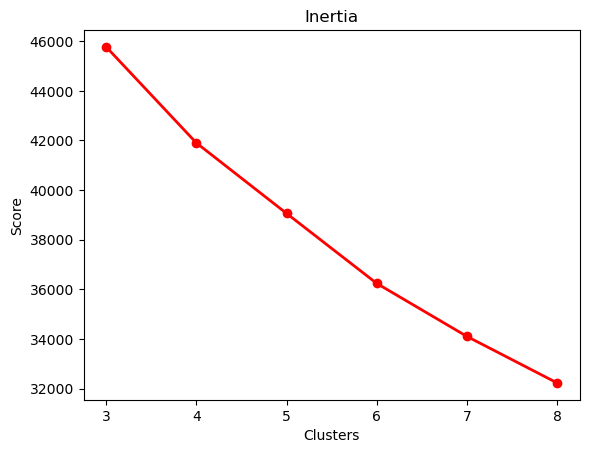

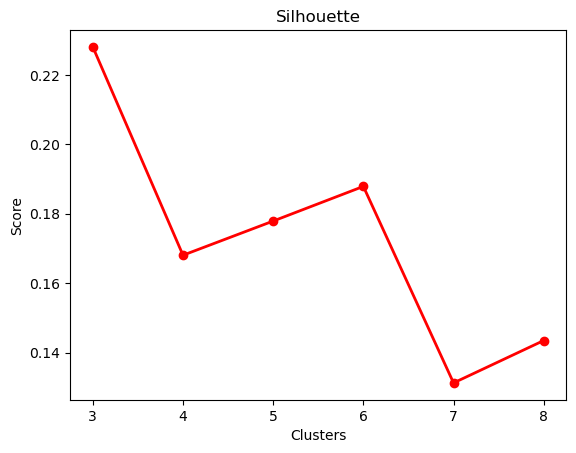

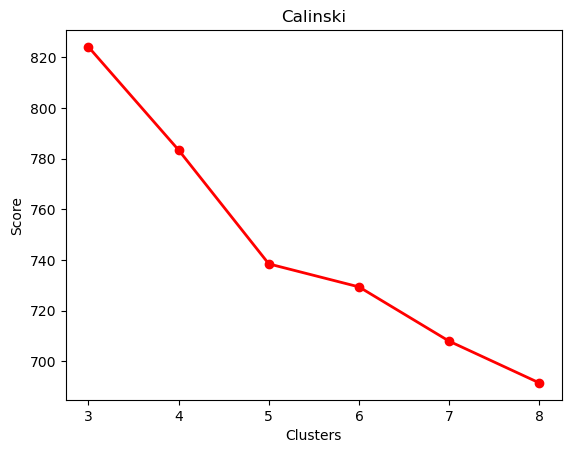

In [59]:
drawElbow( K_LIST, I_LIST, "Inertia" )
drawElbow( K_LIST, S_LIST, "Silhouette" )
drawElbow( K_LIST, C_LIST, "Calinski" )

This go around it looks 3 clusters is the clear winner

In [68]:
pca_final_df.groupby('clusters')['TARGET_BAD_FLAG'].value_counts(normalize=True).sort_index().mul(100).round(1).astype(str) + '%'

clusters  TARGET_BAD_FLAG
0         0                  32.8%
          1                  67.2%
1         0                  85.1%
          1                  14.9%
2         0                  90.0%
          1                  10.0%
3         0                  80.6%
          1                  19.4%
Name: TARGET_BAD_FLAG, dtype: object

In [67]:
merged_with_cluster.groupby('cluster')['TARGET_BAD_FLAG'].value_counts(normalize=True).sort_index().mul(100).round(1).astype(str) + '%'


cluster  TARGET_BAD_FLAG
0        0                  90.1%
         1                   9.9%
1        0                  80.4%
         1                  19.6%
2        0                  31.2%
         1                  68.8%
3        0                  84.8%
         1                  15.2%
Name: TARGET_BAD_FLAG, dtype: object

Doesn't look like it made the clustering more accurate. It did shuffle some things around but nothing super striking. 